In [1]:
from model import create_model
nn4_small2 = create_model()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
nn4_small2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [2]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [3]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        if (self.name == None):
            return os.path.join(self.base, self.file)
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path, is_classified):
    metadata = []
    for i in os.listdir(path):
        if is_classified:
            for f in os.listdir(os.path.join(path, i)):
                # Check file extension. Allow only jpg/jpeg' files.
                ext = os.path.splitext(f)[1]
                if ext == '.jpg' or ext == '.jpeg':
                    metadata.append(IdentityMetadata(path, i, f))
        else: 
            ext = os.path.splitext(i)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, None, i))
            
    return np.array(metadata)

In [4]:
metadata = load_metadata('Batch_Images', False)

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# OpenCV loads images with color channels
# in BGR order. So we need to reverse them
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    # Load an image
    original = load_image(metadata[img_index].image_path())

    # Detect face and return bounding box
    bb = alignment.getAllFaceBoundingBoxes(original)

    cnt = 0
    if len(bb) == 0:
        #  Show original image
        plt.subplot(131)
        plt.imshow(original)
        
    for i in bb:
        
        # Transform image using specified face landmark indices and crop image to 96x96
        aligned = alignment.align(96, original, i, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

        # Show original image
        plt.subplot(131)
        plt.imshow(original)

        # Show original image with bounding box
        plt.subplot(132)
        plt.imshow(original)
        plt.gca().add_patch(patches.Rectangle((i.left(), i.top()), i.width(), i.height(), fill=False, color='red'))

        # Show aligned image
        
        plt.subplot(133)
        plt.imshow(aligned)
        
def show_not_recognized(x, y):
    
    plt.figure(figsize=(10,10))
    
    for img_idx in range(x, y + 1):
        # Load an image
        original = load_image(metadata[img_idx].image_path())

        # Detect face and return bounding box
        bb = alignment.getAllFaceBoundingBoxes(original)

        if len(bb) == 0:
            #  Show original image
            plt.subplot(1, 1, (img_idx % 1) + 1)
            plt.imshow(original)
        for i in bb:
            # Show original image with bounding box
            plt.subplot(1, 1, (img_idx % 1) + 1)
            plt.imshow(original)
            plt.gca().add_patch(patches.Rectangle((i.left(), i.top()), i.width(), i.height(), fill=False, color='red'))

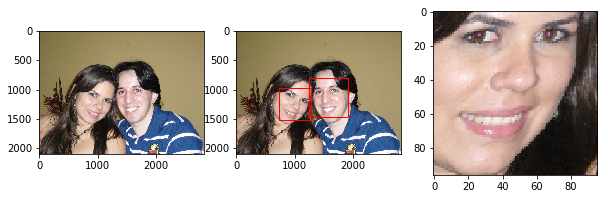

In [10]:
show_original_and_aligned(50)

In [6]:
#define for future use

def align_image(img):
    return alignment.align(96, img, alignment.getAllFaceBoundingBoxes(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [7]:
import random
import string

FACES_DIR = './Batch_Images/Faces/'
LABELED_FACES_DIR = './Batch_Images/Labeled_Faces/'

def generate_random_hex(path):
    letters = string.hexdigits
    rand_name = ''.join(random.choice(letters) for i in range(10))
    
    if (rand_name + '.jpg') in os.listdir(): return generate_random_hex() 

    return rand_name
    
    
def save_image(img, path = FACES_DIR, image_name = '', extension = '.jpg'):
    try:
        os.listdir(path)
    except FileNotFoundError as e:
        os.mkdir(path)
    
    if path[-1] != '/': path = path + '/'
        
    if image_name == '':
        image_name = generate_random_hex(path)
        
    full_img_name = image_name + extension
    full_path = path + full_img_name
    
    if (not cv2.imwrite(full_path, img[...,::-1])):
        raise Exception('Image could not be written')

In [9]:
from progressbar import ProgressBar

progress = ProgressBar(len(metadata))
progress.start()

for i, m, in enumerate(metadata):
    
    original = load_image(m.image_path())
    bounding_boxes = alignment.getAllFaceBoundingBoxes(original) 
    
    if len(bounding_boxes) > 0:
                          
        for bb in bounding_boxes:
            aligned_face = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
            ## Maybe change to send to specific folder
            save_image(aligned_face)
        
    progress.update(i)
    

In [8]:
metadata_faces = load_metadata(LABELED_FACES_DIR, True)

In [9]:
from progressbar import ProgressBar

num_faces = len(metadata_faces)
progress = ProgressBar(num_faces)
progress.start()

embedded = np.zeros((num_faces, 128))

for i, m in enumerate(metadata_faces):
    img = load_image(m.image_path())
    img = (img / 255.).astype(np.float32)
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    progress.update(i)

In [10]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle('Distance = %.2f' % (distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata_faces[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata_faces[idx2].image_path()));    
    
def show_pair_name(img_name1, img_name2):
    for i, m in enumerate(metadata_faces):
        if m.file == img_name1:
            idx1 = i
        if m.file == img_name2:
            idx2 = i
    show_pair(idx1, idx2) 

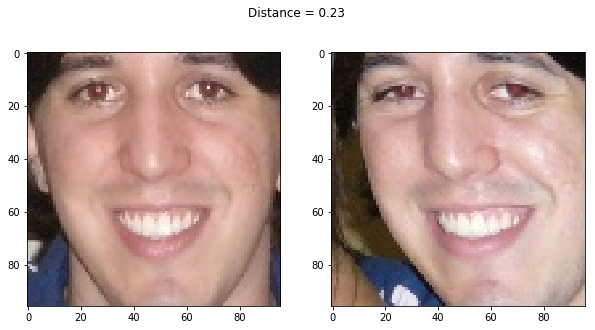

In [11]:
show_pair_name('C4963b44D4.jpg','dAF62c6eB6.jpg')

In [21]:
import requests

NAME_URL = 'https://api.namefake.com/'
NAMES_DIR = './Batch_Images/Labeled_Faces'

def generate_random_name():
    gen = lambda: requests.get(NAME_URL, verify = False).json()['name']
    
    rand_name = gen()
    rand_name = rand_name.replace(' ', '')
    
    if rand_name in os.listdir(NAMES_DIR): return generate_random_name()
    
    return rand_name

In [39]:
for i, m in enumerate(metadata_faces):
    print(i, m.name)

0 p8
1 p8
2 p8
3 p8
4 p8
5 p8
6 p8
7 p8
8 p8
9 p8
10 p8
11 p8
12 p8
13 p8
14 p8
15 p8
16 p8
17 p8
18 p8
19 p8
20 p8
21 p8
22 p8
23 p8
24 p8
25 p8
26 p8
27 p8
28 p17
29 p17
30 p17
31 p11
32 p11
33 p11
34 p11
35 p11
36 p11
37 p11
38 p11
39 p11
40 p11
41 p11
42 p11
43 p11
44 p11
45 p9
46 p9
47 p9
48 p9
49 p9
50 p9
51 p9
52 p9
53 p9
54 p9
55 p9
56 p9
57 p9
58 p9
59 p9
60 p9
61 p9
62 p9
63 p9
64 p9
65 p28
66 p28
67 p28
68 p25
69 p25
70 p25
71 p25
72 p25
73 p6
74 p6
75 p6
76 p6
77 p6
78 p6
79 p6
80 p6
81 p6
82 p6
83 p6
84 p6
85 p6
86 p6
87 p6
88 p6
89 p6
90 p6
91 p6
92 p27
93 p27
94 p27
95 p27
96 p27
97 p27
98 p3
99 p3
100 p3
101 p3
102 p3
103 p3
104 p3
105 p3
106 p3
107 p3
108 p3
109 p3
110 p3
111 p3
112 p3
113 p3
114 p3
115 p3
116 p3
117 p3
118 p3
119 p3
120 p3
121 p3
122 p3
123 p3
124 p23
125 p23
126 p23
127 p23
128 p23
129 p10
130 p10
131 p10
132 p10
133 p10
134 p10
135 p10
136 p10
137 p10
138 p10
139 p10
140 p10
141 p10
142 p10
143 p10
144 p10
145 p10
146 p10
147 p10
148 p18
149 p18
150

# What is the best threshold for the verification problem (Distance Treshold)

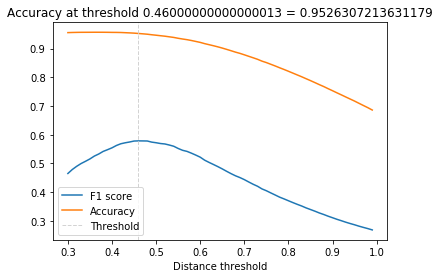

In [12]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata_faces)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata_faces[i].name == metadata_faces[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold ' + str(opt_tau) + ' = ' + str(opt_acc))
plt.xlabel('Distance threshold')
plt.legend();

## Distance distributions of positive and negative pairs

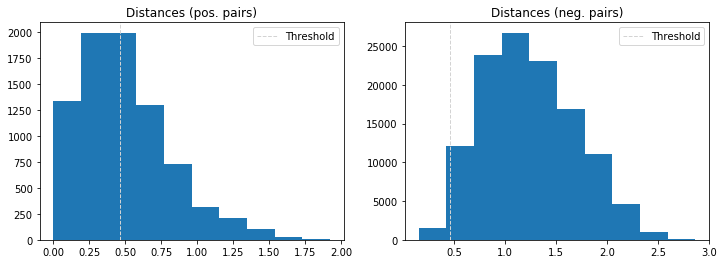

In [13]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Face recognition - with KNN or an SVM

50% used for training  
50% for validation

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata_faces])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata_faces.shape[0]) % 2 != 0
train_idx = np.arange(metadata_faces.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = knn.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print('KNN accuracy = ' + str(acc_knn) + ' , SVM accuracy = ' + str(acc_svc))

KNN accuracy = 0.8722222222222222 , SVM accuracy = 0.8722222222222222


In [16]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = knn.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title('Recognized as ' + str(example_identity));
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata_faces[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title('Recognized as ' + str(example_identity))        

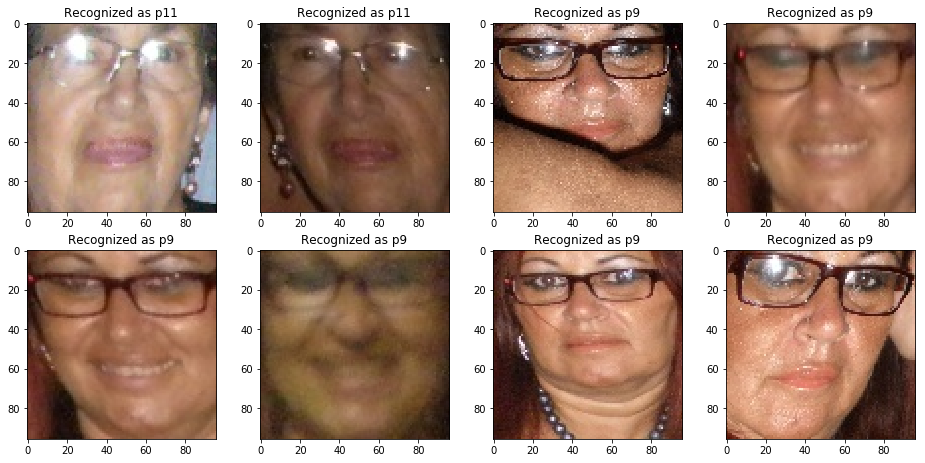

In [18]:
show_predictions(range(20, 28))

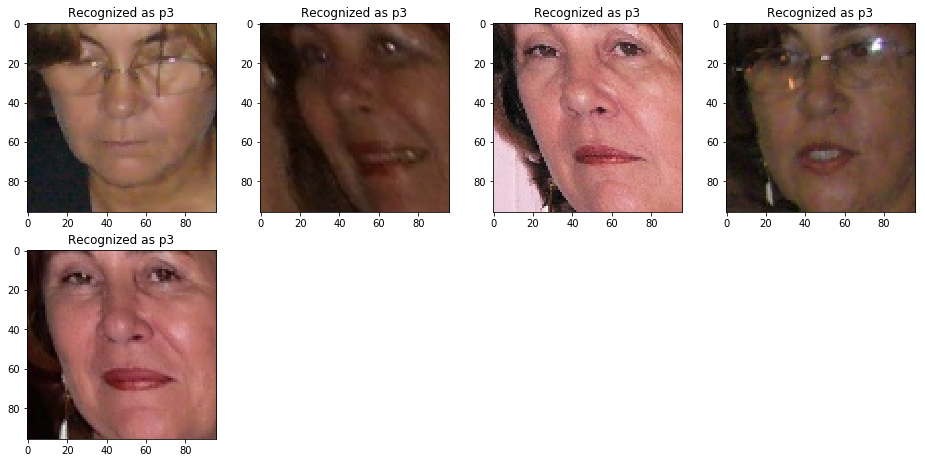

In [51]:
show_predictions(range(55,60))

## Missclassified images

[5, 7, 32, 46, 47, 48, 52, 54, 60, 61, 64, 67, 69, 76, 93, 125, 130, 133, 135, 136, 138, 152, 156]


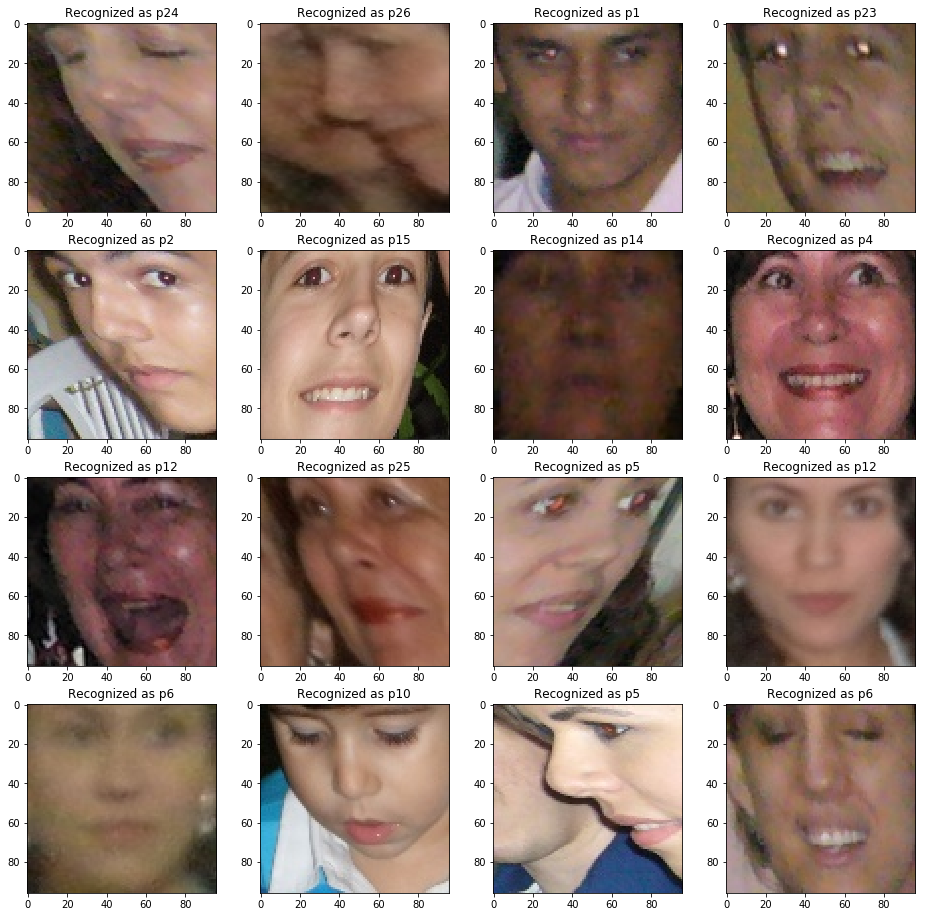

In [19]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)


# Dataset visualization

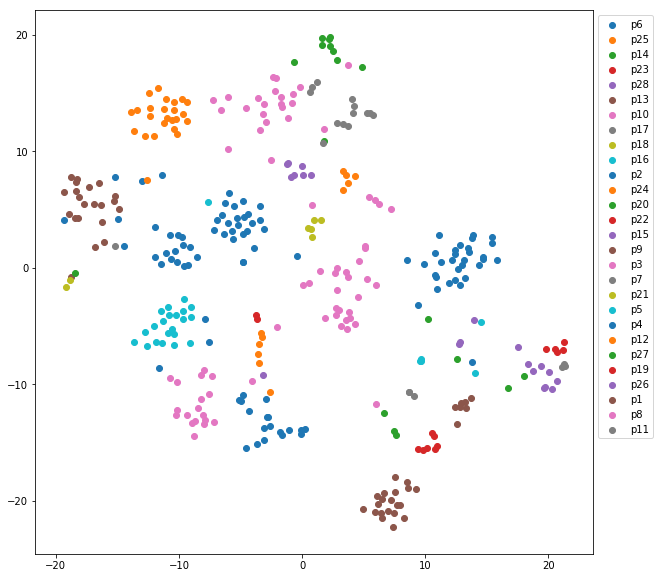

In [25]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));